In [32]:
import numpy as np
import pandas as pd
import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from mllib.params import FieldNames, FileNames
from mllib.utils import load_pickle
from mllib.transformers import ListLen, SetLen, ListAggregation

In [2]:
def make_x_y(x_tr, x_val, flag='val'):
    y_tr = x_tr['redemption_status'].values

    if flag == 'val':
        y_val = x_val['redemption_status'].values
    else:
        y_val = None
    return x_tr, y_tr, x_val, y_val


def get_rank_features(df):
    df['cust_coupon_rank1'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_0'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank2'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_1'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank3'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_2'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank4'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_0'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank5'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_1'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank6'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_2'].rank('max')/df['customer_campaign_count']

    df['customer_rank1'] = df.groupby(['customer_id'])['common_item_set_1'].rank('max')/df.groupby('customer_id').size()
    df['customer_rank2'] = df.groupby(['customer_id'])['common_brand_1'].rank('max')/df.groupby('customer_id').size()
    df['customer_rank3'] = df.groupby(['customer_id'])['common_category_1'].rank('max')/df.groupby('customer_id').size()

    # df['customer_rank4'] = df.groupby(['customer_id'])['common_brand_1'].rank('max')/df.groupby('customer_id').size()
    # df['customer_rank3'] = df.groupby(['customer_id'])['common_item_set_2'].rank('max')/df.groupby('customer_id').size()
    df['campaign_rank1'] = df.groupby(['campaign_id'])['common_item_set_0'].rank('max')/df.groupby('campaign_id').size()
    df['campaign_rank2'] = df.groupby(['campaign_id'])['common_brand_0'].rank('max')/df.groupby('campaign_id').size()

    #df['campaign_rank2'] = df.groupby(['campaign_id'])['common_item_set_1'].rank('max')/df.groupby('campaign_id').size()
    #df['campaign_rank3'] = df.groupby(['campaign_id'])['common_item_set_2'].rank('max')/df.groupby('campaign_id').size()
    #df['coupon_rank1'] = df.groupby(['coupon_id'])['common_item_set_0'].rank('max')/df.groupby('coupon_id').size()
    df['coupon_rank1'] = df.groupby(['coupon_id'])['common_brand_0'].rank('max')/df.groupby('coupon_id').size()

    #df['coupon_rank2'] = df.groupby(['coupon_id'])['common_item_set_1'].rank('max')/df.groupby('coupon_id').size()

    return df


def load_data(flag='val'):
    if flag == 'val':
        x_tr = load_pickle(FileNames.tr_features_v1)
        x_val = load_pickle(FileNames.val_features_v1)
    elif flag == 'test':
        x_tr = load_pickle(FileNames.train_features_v1)
        x_val = load_pickle(FileNames.test_features_v1)
    
    return make_x_y(x_tr, x_val, flag=flag)


def map_campign_id(x_tr, x_val, flag='val'):
    if flag == 'val':
        tr = load_pickle(FileNames.tr_v2)
        val = load_pickle(FileNames.val_v2)
    elif flag == 'test':
        tr = load_pickle(FileNames.train_v2)
        val = load_pickle(FileNames.test_v2)
        
    x_tr['campaign_id'] = tr['campaign_id'].values
    x_val['campaign_id'] = val['campaign_id'].values
    return x_tr, x_val

In [3]:
from mllib.targetencoder import TargetEncoderWithThresh

In [85]:
x_tr, y_tr, x_val, y_val = load_data('val')
x_tr, x_val = map_campign_id(x_tr, x_val, 'val')

In [86]:
n_feats = x_tr.shape[1] - 1
n_feats

387

In [87]:
x_tr = get_rank_features(x_tr)
x_val = get_rank_features(x_val)

In [88]:
#tr = load_pickle(FileNames.tr_v2)
#val = load_pickle(FileNames.val_v2)
#hist_artifact = load_pickle(FileNames.cust_tr_artifact1)


def map_brand_categories(x_tr, tr, hist):
    agg = ListAggregation(date_col= FieldNames.campaign_start_date, user_col=FieldNames.customer_id,
                key_col=FieldNames.item_brand_type, hist_artifact=hist)
    
    tmp = agg.transform(tr)
    x_tr['num_est'] = np.array([sum([val == 'Established' for val in x]) for x in tmp.tolist()])
    x_tr['num_local'] = [sum([val == 'Local' for val in x]) for x in tmp.tolist()]
    
    agg = ListAggregation(date_col= FieldNames.campaign_start_date, user_col=FieldNames.customer_id,
                key_col=FieldNames.item_category, hist_artifact=hist)
    tmp = agg.transform(tr)
    x_tr['num_pharma'] = [sum([val == 'Pharmaceutical' for val in x]) for x in tmp.tolist()]
    x_tr['num_grocery'] = [sum([val == 'Grocery' for val in x]) for x in tmp.tolist()]
    return x_tr



In [89]:
#x_tr = map_brand_categories(x_tr, tr, hist_artifact)
#x_val = map_brand_categories(x_val, val, hist_artifact)

In [90]:
y_tr = y_tr[x_tr.coupon_id != 8]
x_tr = x_tr.loc[x_tr.coupon_id != 8]


In [91]:
lgb_params = {
    "n_estimators": 100000,
    "boosting_type": "gbdt",
    "num_leaves": 3,
    "max_depth": 4,
    "colsample_bytree": 0.45,
    "metric": None,
    "subsample": 0.7,
    "learning_rate": 0.004,
    "reg_lambda": 1,
    "reg_alpha": 1,
    "min_data_in_leaf": 713,
    "min_child_samples": 200,
    "max_bin": 255,
    "cat_smooth": 50,
    "max_cat_threshold": 32,
    "cat_l2": 50,
    "seed": 786,
    "allow_nan": True
}
model = lgb.LGBMClassifier(**lgb_params)

feats = [f for i, f in enumerate(x_tr.columns) if ('coupon_details' not in f) and ('common_repeats' not in f) and
         (f not in ['campaign_id', 'customer_campaign_count', 'redemption_status']) and (i not in [19, 37, 45, 46, 47,
                                                                              383])] 
#xx_tr = qnt.fit_transform(x_tr[feats].fillna(-999))
#xx_val = qnt.fit_transform(x_val[feats].fillna(-999))
model.fit(x_tr[feats], y_tr, eval_set=[(x_tr[feats], y_tr), (x_val[feats], y_val)], eval_metric='auc', verbose=50, early_stopping_rounds=400) 
val_preds = model.predict_proba(x_val[feats])[:, 1]

Training until validation scores don't improve for 400 rounds
[50]	valid_0's auc: 0.900129	valid_1's auc: 0.909461
[100]	valid_0's auc: 0.901983	valid_1's auc: 0.912646
[150]	valid_0's auc: 0.903814	valid_1's auc: 0.913109
[200]	valid_0's auc: 0.905114	valid_1's auc: 0.914702
[250]	valid_0's auc: 0.907625	valid_1's auc: 0.916687
[300]	valid_0's auc: 0.910655	valid_1's auc: 0.919131
[350]	valid_0's auc: 0.912249	valid_1's auc: 0.919823
[400]	valid_0's auc: 0.914803	valid_1's auc: 0.921036
[450]	valid_0's auc: 0.916323	valid_1's auc: 0.922712
[500]	valid_0's auc: 0.918565	valid_1's auc: 0.924724
[550]	valid_0's auc: 0.920168	valid_1's auc: 0.926826
[600]	valid_0's auc: 0.922057	valid_1's auc: 0.928699
[650]	valid_0's auc: 0.923385	valid_1's auc: 0.929917
[700]	valid_0's auc: 0.924218	valid_1's auc: 0.93116
[750]	valid_0's auc: 0.92502	valid_1's auc: 0.932212
[800]	valid_0's auc: 0.925836	valid_1's auc: 0.932807
[850]	valid_0's auc: 0.927028	valid_1's auc: 0.934105
[900]	valid_0's auc: 0.

In [92]:
x_train, y_train, x_test, _ = load_data('test')
x_train, x_test = map_campign_id(x_train, x_test, 'test')
x_train = get_rank_features(x_train)
x_test = get_rank_features(x_test)

#train = load_pickle(FileNames.train_v2)
#test = load_pickle(FileNames.test_v2)
#hist_artifact = load_pickle(FileNames.cust_train_artifact1)
#x_tr = map_brand_categories(x_tr, tr, hist_artifact)
#x_val = map_brand_categories(x_val, val, hist_artifact)

y_train = y_train[x_train.coupon_id != 8]
x_train = x_train.loc[x_train.coupon_id != 8]

#cvlist = StratifiedKFold(10, random_state=123).split(x_tr, y_tr)
#x_tr['cust_trenc'] = cross_val_predict(trenc, x_tr, y_tr, cv=cvlist, n_jobs=-1, method='transform')
#x_val['cust_trenc'] = trenc.fit(x_tr).transform(x_val)

In [93]:
lgb_params['n_estimators'] = 4700
model = lgb.LGBMClassifier(**lgb_params)

model.fit(x_train[feats], y_train, eval_set=[(x_train[feats], y_train)], eval_metric='auc', verbose=50)
test_preds = model.predict_proba(x_test[feats])[:, 1]

[50]	valid_0's auc: 0.904669
[100]	valid_0's auc: 0.909066
[150]	valid_0's auc: 0.91147
[200]	valid_0's auc: 0.913163
[250]	valid_0's auc: 0.917014
[300]	valid_0's auc: 0.920692
[350]	valid_0's auc: 0.922345
[400]	valid_0's auc: 0.92406
[450]	valid_0's auc: 0.925751
[500]	valid_0's auc: 0.926375
[550]	valid_0's auc: 0.928574
[600]	valid_0's auc: 0.93015
[650]	valid_0's auc: 0.931756
[700]	valid_0's auc: 0.932926
[750]	valid_0's auc: 0.933881
[800]	valid_0's auc: 0.934808
[850]	valid_0's auc: 0.935426
[900]	valid_0's auc: 0.935886
[950]	valid_0's auc: 0.936279
[1000]	valid_0's auc: 0.936948
[1050]	valid_0's auc: 0.937548
[1100]	valid_0's auc: 0.937949
[1150]	valid_0's auc: 0.938446
[1200]	valid_0's auc: 0.938864
[1250]	valid_0's auc: 0.939297
[1300]	valid_0's auc: 0.939662
[1350]	valid_0's auc: 0.939994
[1400]	valid_0's auc: 0.940301
[1450]	valid_0's auc: 0.940548
[1500]	valid_0's auc: 0.94086
[1550]	valid_0's auc: 0.94113
[1600]	valid_0's auc: 0.941417
[1650]	valid_0's auc: 0.941647
[1

/home/mohsin/kg7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


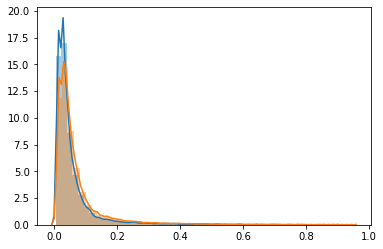

In [94]:
sns.distplot(np.sqrt(val_preds))
sns.distplot(np.sqrt(test_preds))

In [95]:
test = pd.read_csv('data/test.csv')
sub = test[['id']]
sub['redemption_status'] = test_preds
sub.head()

/home/mohsin/kg7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,redemption_status
0,3,0.392643
1,4,0.012221
2,5,0.009367
3,8,0.000737
4,10,0.000828


In [96]:
sub.to_csv('data/sub_model12.csv', index=False)

In [97]:
sube1 = pd.read_csv('sub_en1.csv')
sub1 = pd.read_csv('data/sub_v8.csv')
tmp = pd.read_csv('data/tmp.csv')

In [16]:
from scipy.stats import spearmanr

In [17]:
spearmanr(test_preds, tmp.redemption_status)

SpearmanrResult(correlation=0.9652978032142759, pvalue=0.0)

In [18]:
spearmanr(sube1.redemption_status, sub1.redemption_status)

SpearmanrResult(correlation=0.9909411963163374, pvalue=0.0)

In [19]:
spearmanr(test_preds, sub1.redemption_status)

SpearmanrResult(correlation=0.9635289084651666, pvalue=0.0)

In [20]:
spearmanr(test_preds, sube1.redemption_status)

SpearmanrResult(correlation=0.9759449673820652, pvalue=0.0)